In [122]:
import torch
import os
import numpy as np
import matplotlib.pyplot as plt
import copy
import GPUtil
from collections import defaultdict
from analysis import utils as au
from analysis import plotting
from data import utils as du
from data import se3_diffuser
from data import so3_diffuser
from data import r3_diffuser
from model import loss
import tree
from data import rosetta_data_loader
from data import digs_data_loader
from experiments import train_se3_diffusion
from openfold.utils import rigid_utils as ru
from scipy.spatial.transform import Rotation

from omegaconf import OmegaConf
import importlib

# Enable logging
import logging
import sys
date_strftime_format = "%Y-%m-%y %H:%M:%S"
logging.basicConfig(stream=sys.stdout, level=logging.INFO, format="%(asctime)s %(message)s", datefmt=date_strftime_format)

In [123]:
importlib.reload(rosetta_data_loader)
importlib.reload(digs_data_loader)
importlib.reload(se3_diffuser)
importlib.reload(so3_diffuser)
importlib.reload(du)
importlib.reload(train_se3_diffusion)

<module 'experiments.train_se3_diffusion' from '/home/jyim/Projects/protein_diffusion_v2/experiments/train_se3_diffusion.py'>

In [124]:
# Load config.
conf = OmegaConf.load('../config/base.yaml')

# Redirect cache from notebook directory.
exp_conf = conf.experiment
exp_conf.data_location = 'digs'

data_conf = conf.data
data_conf.digs.filtering.subset = 1
data_conf.digs.fraction_fb = 0.0

In [ ]:
exp = train_se3_diffusion.Experiment(conf=conf)
train_loader, train_sampler, valid_loader, valid_sampler = exp.create_digs_dataset(0, 1)

In [ ]:
# Extract a protein backbone.
train_iter = iter(train_loader)
next_item = next(train_iter)
res_mask = next_item['res_mask'][0, :]
ca_pos = next_item['xyz'][0, :, 1, :][res_mask.bool()]

# Translations

In [ ]:
class Diffuser:
    """SDE diffuser class for translations."""

    def __init__(
            self,
            min_b,
            max_b,
            sde='vp',
        ):
        """
        Args:
            min_b: starting value in variance schedule.
            max_b: ending value in variance schedule.
        """
        self.min_b = min_b
        self.max_b = max_b
        self.sde = sde

    def b_t(self, t):
        return torch.tensor(self.min_b + t*(self.max_b - self.min_b))
    
    def g_t(self, t):
        return torch.sqrt(self.b_t(t))

    def f(self, x, t):
        """f is the time-dependent drift coefficient
        
        Args:
            VP: set True for variance preserving, otherwise variance exploding
        """
        if self.sde == 'vp':
            return -1/2 * self.g_t(t)**2
        else:
            return 0.0
        
    def bar_alpha(self, t):
        """bar_alpha returns the weighting factor on x_0 for the VP SDE
        
        """
        return torch.exp(-(1/2)*(t**2)*(self.max_b-self.min_b) - t*self.min_b)
    
    def sigma_t_sqr(self, t):
        """sigma_t_sqr is the variance of p(x(t) | x(0)) for VE SDE
        """
        return t*self.min_b + (1/2)*(t**2)*(self.max_b-self.min_b)
        
    def weighting_factor_and_variance(self, t, VP=True):
        """weighting_factor_and_variance returns a and b such that
        p(x(t) | x(0)) = N(a*x(0), b)
        """
        
        if self.sde == 'vp':
            return torch.sqrt(self.bar_alpha(t)), 1 - self.bar_alpha(t)
        else:
            return 1., self.sigma_t_sqr(t)
    
    
    def forward_diffusion(self, t, dt, xt):
        d_trans = torch.normal(
            mean=self.f(xt, t) * xt * dt,
            std=self.g_t(t) * torch.sqrt(dt)
        )
        xt_1 = xt + d_trans
        return xt_1
    
    def forward_diffusion_marginal(self, t, x0):
        a_trans, b_trans = self.weighting_factor_and_variance(t)
        trans_t = torch.normal(
            mean=a_trans * x0,
            std=torch.sqrt(b_trans)
        )
        return trans_t
        
    def reverse_diffusion(self, t, dt, xt, s_theta):
        gt = self.g_t(t)
        ft_trans = self.f(xt, t)*xt
        d_trans = torch.normal(
            mean=(ft_trans - gt**2 * s_theta)*dt,
            std=gt*torch.sqrt(dt)
        )
        return xt - d_trans
 
    def score(self, xt, x0, t):
        return -(xt - torch.sqrt(self.bar_alpha(t)) * x0) / (1-self.bar_alpha(t))


## Simulating reverse diffusion

In [24]:
min_b = 0.1
max_b = 20
num_t = 100
dt = torch.tensor(1 / num_t)
r3_diffuser = Diffuser(min_b = min_b, max_b = max_b)

In [36]:
x0 = torch.clone(ca_pos)
x1 = torch.normal(mean=0, std=1.0, size=x0.shape)
reverse_t = np.linspace(0, 1, num_t)[::-1]
all_steps = [x1]
all_scores = []
for i in range(num_t-1):
    t = torch.tensor(reverse_t[i])
    xt = all_steps[-1]
    score_t = r3_diffuser.score(xt, x0, t)
    all_scores.append(score_t)
    x_t_1 = r3_diffuser.reverse_diffusion(t, dt, x_t, score_t)
    all_steps.append(x_t_1)

/scratch/jyim/52212185/ipykernel_2186702/3645239646.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.min_b + t*(self.max_b - self.min_b))


In [ ]:
# Plot out SE(3)
f, axes = plt.subplots(1, 3, figsize=[24, 8], subplot_kw=dict(projection="3d"))
scale_factor = conf.data.digs.scale_factor
ax_lim = 15.

curr_step_ca = all_steps[0]
plotting.plt_3d(curr_step_ca, axes[0], color='r', s=100, mode='scatter')
plotting.plt_3d(curr_step_ca, axes[0], color='r', mode='line')

curr_step_ca = all_steps[-50]
plotting.plt_3d(curr_step_ca, axes[1], color='r', s=100, mode='scatter')
plotting.plt_3d(curr_step_ca, axes[1], color='r', mode='line')

curr_step_ca = all_steps[-1]
plotting.plt_3d(curr_step_ca, axes[2], color='r', s=100, mode='scatter')
plotting.plt_3d(curr_step_ca, axes[2], color='r', mode='line')


## Simulating forward marginals

In [33]:
min_b = 0.1
max_b = 20
num_t = 100
dt = torch.tensor(1 / num_t)
r3_diffuser = Diffuser(min_b = min_b, max_b = max_b)

In [34]:
x0 = torch.clone(ca_pos[2])

marginal_samples = {}
for i,t in enumerate(torch.linspace(0, 1, num_t)):
    marginal_samples[i] = []
    for _ in range(500):
        marginal_samples[i].append(
            r3_diffuser.forward_diffusion_marginal(t, x0)
        )


In [35]:
# Compute reverse samples.
reverse_samples = {}
for _ in range(500):
    curr_step = torch.normal(mean=0, std=1.0, size=x0.shape)
    for i, t in reversed(list(enumerate(torch.linspace(0, 1, num_t)))):
        if i not in reverse_samples:
            reverse_samples[i] = []
        score_t = r3_diffuser.score(curr_step, x0, t)
        curr_step = r3_diffuser.reverse_diffusion(t, dt, curr_step, score_t)
        reverse_samples[i].append(torch.clone(curr_step))

/scratch/jyim/52212185/ipykernel_2224476/2553580008.py:20: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return torch.tensor(self.min_b + t*(self.max_b - self.min_b))


In [ ]:
ts = [2, 10, 20, 50, 98]
f, axes = plt.subplots(len(ts), 2, figsize=[20, 4*len(ts)])
for i,t in enumerate(ts):
    for j in range(2):
        reverse_i = torch.stack(reverse_samples[t])[:, j]
        forward_i = torch.stack(marginal_samples[t])[:, j]
        axes[i, j].hist(reverse_i.numpy(), bins=10, density=True, label='reverse')
        axes[i, j].hist(forward_i.numpy(), bins=10, density=True, label='forrward')
        axes[i, j].set_xlim(-8, 8)
        axes[i, j].set_title(f't={t},coord={j}')
        axes[i, j].legend(loc="upper left")


# Rotations

In [125]:
diff_conf = conf.diffuser
num_sigma = 1000
num_omega = 1000
min_sigma = 0.1
max_sigma = 1.5

In [126]:
rot_diff = so3_diffuser.SO3Diffuser(
    cache_dir=diff_conf.igso3_cache_dir,
    num_sigma=num_sigma,
    num_omega=num_omega,
    min_sigma=min_sigma,
    max_sigma=max_sigma,
)

INFO: Using cached IGSO3.


## Simulating diffusion

In [127]:
num_t = 100
forward_t = np.linspace(1e-5, 1, num_t)
reverse_t = forward_t[::-1]
dt = 1 / num_t

In [129]:
# Forward diffusion
rot_0 = np.zeros_like(rot_1)
marginal_samples = {}
for i,t in enumerate(forward_t):
    marginal_samples[i] = []
    for _ in range(500):
        marginal_samples[i].append(
            rot_diff.forward_marginal(rot_0, t)[0])

In [136]:
# Reverse diffusion
reverse_samples = {}
for _ in range(500):
    curr_step = rot_diff.sample(1, n_samples=1)
    for i, t in reversed(list(enumerate(forward_t))):
        if i not in reverse_samples:
            reverse_samples[i] = []
        score_t = rot_diff.score(curr_step, t)
        curr_step = rot_diff.reverse(
            rot_t=curr_step,
            score_t=score_t,
            t=t,
            dt=dt)
        reverse_samples[i].append(copy.deepcopy(curr_step))

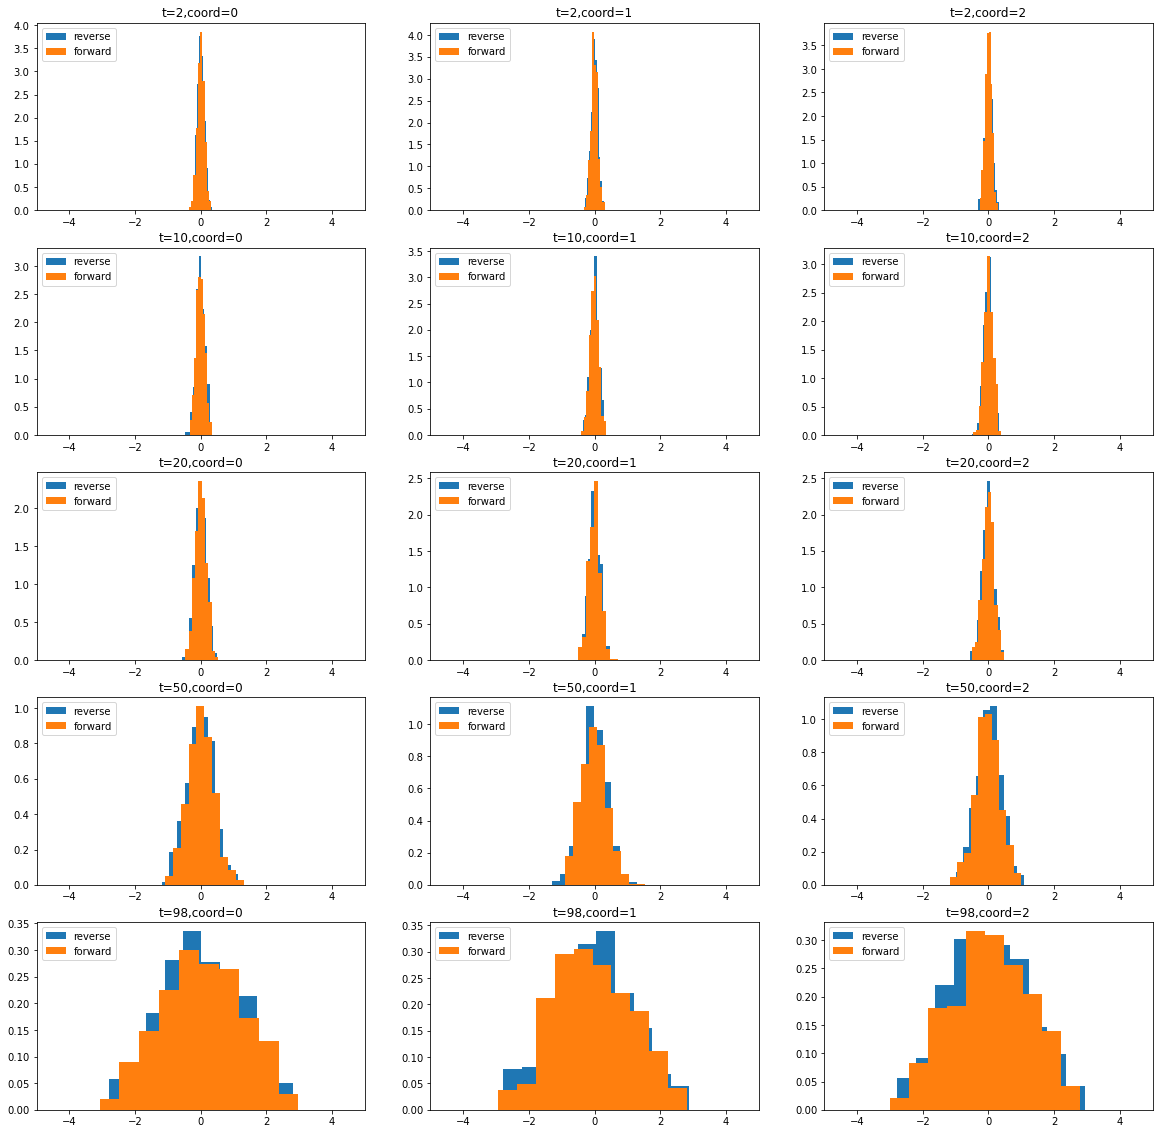

In [137]:
ts = [2, 10, 20, 50, 98]
f, axes = plt.subplots(len(ts), 3, figsize=[20, 4*len(ts)])
for i,t in enumerate(ts):
    for j in range(3):
        reverse_i = np.stack(reverse_samples[t])[:, 0, j]
        axes[i, j].hist(reverse_i, bins=10, density=True, label='reverse')

        forward_i = np.stack(marginal_samples[t])[:, 0, j]
        axes[i, j].hist(forward_i, bins=10, density=True, label='forward')

        axes[i, j].set_xlim(-5, 5)
        axes[i, j].set_title(f't={t},coord={j}')
        axes[i, j].legend(loc="upper left")


In [ ]:
all_steps = [rot_1]
for t in reverse_t:
    rot_t = copy.deepcopy(all_steps[-1])
    score_t = rot_diff.score(rot_t, t)
    rot_t_1 = rot_diff.reverse(
        rot_t=rot_t,
        score_t=score_t,
        t=t,
        dt=dt)
    all_steps.append(rot_t_1)

In [57]:
# Reverse diffusion
reverse_samples = {}
for _ in range(500):
    curr_step = rot_diff.sample(1, n_samples=1)
    for i, t in enumerate(reverse_t):
        if i not in reverse_samples:
            reverse_samples[i] = []
        score_t = rot_diff.score(curr_step, t)
        curr_step = rot_diff.reverse(
            rot_t=du.compose_rotvec(rot_0, curr_step),
            score_t=score_t,
            t=t,
            dt=dt)
        reverse_samples[i].append(copy.deepcopy(curr_step))

In [ ]:
all_steps[-1]

In [ ]:
rot_0

In [ ]:
all_steps = [rot_1]
for t in reverse_t:
    rot_t = copy.deepcopy(all_steps[-1])
    score_t = rot_diff.score(rot_t, t)
    rot_t_1 = rot_diff.reverse(
        rot_t=rot_t,
        score_t=score_t,
        t=t,
        dt=dt)
    all_steps.append(rot_t_1)

In [ ]:
reverse_t = np.linspace(0, 1, num_sigma)[::-1]
all_steps = [x1]
for i in range(num_t-1):
    t = torch.tensor(reverse_t[i])
    xt = all_steps[-1]
    x_t_1 = rot_diffuser.reverse_diffusion(t, dt, x_t, score_t)
    all_steps.append(x_t_1)

In [100]:
x0 = torch.normal(mean=0, std=1.0, size=(1, 3))
x0 = (x0 / torch.linalg.norm(x0)) * np.random.uniform(0, np.pi)
x1 = rot_diffuser.sample_vec(1.5)

In [106]:
np.cumprod([1, 2, 3])[-1]

6

In [ ]:
reverse_t = np.linspace(0, 1, num_sigma)[::-1]
all_steps = [x1]
for i in range(num_t-1):
    t = torch.tensor(reverse_t[i])
    xt = all_steps[-1]
    x_t_1 = rot_diffuser.reverse_diffusion(t, dt, x_t, score_t)
    all_steps.append(x_t_1)

In [69]:
ts = np.linspace(0, 1, num_sigma)[1:]
sigmas = rot_diffuser.sigma(ts)

In [80]:
t = ts
sigma = 10 ** (t * (np.log10(rot_diffuser.max_sigma) - np.log10(rot_diffuser.min_sigma)) + np.log10(rot_diffuser.min_sigma))
sigma_idx = (np.log10(sigma) - np.log10(rot_diffuser.min_sigma)) / (np.log10(rot_diffuser.max_sigma) - np.log10(rot_diffuser.min_sigma)) * rot_diffuser.num_sigma
sigma_idx = np.clip(
    np.around(sigma_idx).astype(int), a_min=0, a_max=rot_diffuser.num_sigma)

In [ ]:
sigma_idx

In [78]:
sigma_idx = (np.log10(sigma) - np.log10(rot_diffuser.min_sigma)) / (np.log10(rot_diffuser.max_sigma) - np.log10(rot_diffuser.min_sigma)) * rot_diffuser.num_sigma
print(sigma_idx)

1.0010010010010004


In [75]:
sigma = sigmas[0]
sigma_idx = (np.log10(sigma) - np.log10(rot_diffuser.min_sigma)) / (np.log10(rot_diffuser.max_sigma) - np.log10(rot_diffuser.min_sigma)) * rot_diffuser.num_sigma
print(sigma_idx)

5.13902053753119


In [ ]:
sigma_idx = (np.log10(sigma) - np.log10(rot_diffuser.min_sigma)) / (np.log10(rot_diffuser.max_sigma) - np.log10(rot_diffuser.min_sigma)) * rot_diffuser.num_sigma
sigma_idx = np.clip(
    np.around(sigma_idx).astype(int), a_min=0, a_max=self.num_sigma)

In [70]:
sigma_idx = rot_diffuser.sigma_idx(sigmas)

In [ ]:
sigma_idx

In [ ]:
# Plot out SE(3)
f, axes = plt.subplots(1, 3, figsize=[24, 8], subplot_kw=dict(projection="3d"))
scale_factor = conf.data.digs.scale_factor
ax_lim = 15.

curr_step_ca = all_steps[0]
plotting.plt_3d(curr_step_ca, axes[0], color='r', s=100, mode='scatter')
plotting.plt_3d(curr_step_ca, axes[0], color='r', mode='line')

curr_step_ca = all_steps[-50]
plotting.plt_3d(curr_step_ca, axes[1], color='r', s=100, mode='scatter')
plotting.plt_3d(curr_step_ca, axes[1], color='r', mode='line')

curr_step_ca = all_steps[-10]
plotting.plt_3d(curr_step_ca, axes[2], color='r', s=100, mode='scatter')
plotting.plt_3d(curr_step_ca, axes[2], color='r', mode='line')


In [ ]:
min_b = 0.1
max_b = 20
r3_diffuser = Diffuser(min_b = min_b, max_b = max_b)

In [ ]:
num_t = 100
x0 = ca_pos
dt = torch.tensor(1/num_t)

all_steps = [torch.clone(x0)]
all_scores = []
for t in np.linspace(0, 1, num_t):
    next_step = r3_diffuser.forward_diffusion(t, dt, all_steps[-1])
    score_t = r3_diffuser.score(t, dt, all_steps[-1])
    all_scores
    all_steps.append(next_step)

In [ ]:
N = 1000
K = 5
x_1 = torch.normal(mean=0, std=1, size=[N])
xts = [
    
]


In [61]:
class normal_mixture:
    
    def __init__(self, K=3):
        self.K = K
        self.mu = torch.normal(mean=0, std=1, size=[K])
        self.std = 0.1
        
    def sample(self, N):
        idcs = torch.multinomial(torch.ones([self.K])/self.K, num_samples=N, replacement=True)
        mu = self.mu[idcs]
        return mu + torch.normal(mean=0, std=self.std, size=[N])
    
    
    def density(self, x):
        """up to proportionality"""
        ps = [torch.exp(-0.5*(x-self.mu[k])**2/(self.std**2)) for k in range(self.K)]
        ps = torch.stack(ps).sum(axis=0)
        return ps
    
    def score(self, x):
        x = torch.tensor(x, requires_grad=True)
        log_p = torch.log(self.density(x)).sum()
        return torch.autograd.grad(log_p, x)[0]

In [63]:
k = 5
mix = normal_mixture(k)

In [64]:
N = 1000
mix_samples = mix.sample(N)
mix_scores = mix.density(mix_samples)


TypeError: multinomial(): argument 'num_samples' must be int, not Tensor